# Homework set 5

Before you turn this problem in, make sure everything runs as expected (in the menubar, select Kernel → Restart Kernel and Run All Cells...).

Please **submit this Jupyter notebook through Canvas** no later than **Mon Dec. 4, 9:00**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. A pdf version can be made using the save and export option in the Jupyter Lab file menu.**

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

Koen Weverink (14711982) & Jasper Timmer (12854328)

# Exercise 1 (6 points)

A bacterial population $P$ grows according to the geometric progression

$$P_t = rP_{t-1}$$

Where r is the growth rate. The following population counts $P_1 ,\ldots, P_8$ (in billions) are observed:

In [72]:
import numpy as np

data = np.array( [0.19, 0.36, 0.69, 1.3, 2.5, 4.7, 8.5, 14] )

# (a)
Read chapter 6.6 on Nonlinear Least squares. Use the Gauss-Newton Method to fit the model function $f(t, x_1, x_2) = x_1\!\cdot x_2^t$ to the data. Find estimates for the initial population $P_0=x_1$ and the growth rate $r=x_2$. Implement the Gauss-Newton method yourself. You may use linear algebra functions from `scipy` and `numpy`. Plot the datapoints and the curve fitted to the data in a semilogarithmic plot.

It is best if you define your function for Gauss-Newton separately from the definitions associated with the bacterial model.

In [73]:
def residual(params, n, y, fitting_function):
    return y - fitting_function(params, n)

def jacobian(params, n, x, fitting_function):
    """
    Calculate Jacobian using central finite difference method
    """ 
    h = 1e-10
    n_params = len(params)
    jac = np.zeros((len(x), n_params))

    for i in range(n_params):
        delta = np.zeros(n_params)
        delta[i] = h
        jac[:, i] = (fitting_function(params + delta, n) - fitting_function(params - delta, n)) / (2 * h)

    return jac

def gauss_newton(params_init, n, x, y, fitting_function, max_iterations=1000 , tol=1e-6):

    for i in range(max_iterations):
        params = params_init[:]
        res = residual(params, n, y, fitting_function)
        jac = jacobian(params, n, x, fitting_function)

        J_T = jac.T
        A = J_T @ jac
        step = np.linalg.lstsq(A, J_T @ res, rcond=None)[0]

        # step = np.linalg.lstsq(jac, res)[0]
        params += step

        if np.linalg.norm(step) < tol or np.linalg.norm(res) < tol:
            break

    return params

In [74]:
def growth(params, n):
    p_0, r = params
    return p_0 * (r ** np.arange(int(n)))

Fitted parameters:
p_0: -7.470250566069154e-11
r: -40.685651894368824


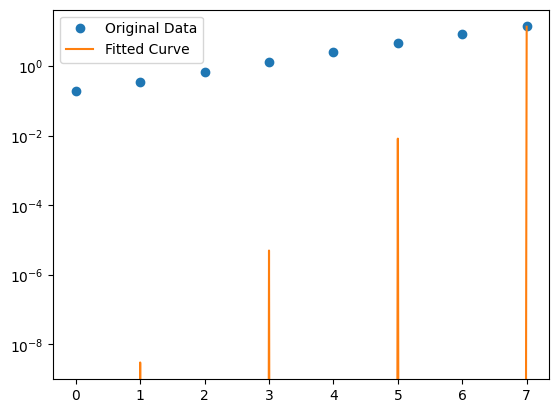

In [75]:
import matplotlib.pyplot as plt

initial_guess = np.array([data[0], 1.0])
n = len(data)

result_params = gauss_newton(initial_guess, n, np.arange(len(data)), data, growth)

p_0_fit, r_fit = result_params
fit_curve = growth((p_0_fit, r_fit), n)

print("Fitted parameters:")
print("p_0:", p_0_fit)
print("r:", r_fit)

plt.semilogy(np.arange(len(data)), data, 'o', label='Original Data')
plt.semilogy(np.arange(len(data)), fit_curve, label='Fitted Curve')
plt.legend()
plt.show()

# (b)
Let $f$ be a vector valued function $f = [ f_1, \ldots, f_m ]^T$. In weighted least squares one aims to minimize the objective function
$$
  \phi(x) = \frac{1}{2} \sum_{i=1}^m W_{ii} ( y_i - f_i(x)) ^2 , \qquad
  W_{ii} = \frac{1}{\sigma_i^2} , 
$$
where $\sigma_i$ is an estimate of the standard deviation in the data point $y_i$. This is equivalent to the standard least squares problem 
$$
\min_x \frac{1}{2} \| Y - F(x) \|_2^2
$$
with $F_i(x) = \frac{1}{\sigma_i} f(x)$  , $Y_i = \frac{1}{\sigma_i} y_i$. Assume that for each data point $y_i$ in the list above, the estimate for the standard deviation is given by
$$
  \sigma_i = 0.05 y_i .
$$ 
Perform a weighted least squares fit to obtain estimates for $P_0$ and $r$. 

Plot the datapoints and the curve fitted to the data again in a semilogarithmic plot.

Compare the residuals, i.e. the values of $y_i - f_i(x)$) obtained in (a) and (b), and discuss the differences between the results of the weighted and the unweighted optimization.


In [76]:
def residual(params, n, y, fitting_function, weights):
    return weights * (y - fitting_function(params, n))


def jacobian(params, n, x, fitting_function, weights):
    h = 1e-10
    n_params = len(params)
    jac = np.zeros((len(x), n_params))

    for i in range(n_params):
        delta = np.zeros(n_params)
        delta[i] = h
        jac[:, i] = (weights * (fitting_function(params + delta, n) - fitting_function(params - delta, n))) / (2 * h)

    return jac

def weighted_least_squares(params_init, n, x, y, fitting_function, weights, max_iterations=1000, tol=1e-6):
    for i in range(max_iterations):
        params = params_init[:]
        res = residual(params, n, y, fitting_function, weights)
        jac = jacobian(params, n, x, fitting_function, weights)

        J_T = jac.T
        A = J_T @ jac
        step = np.linalg.lstsq(A, J_T @ res, rcond=None)[0]
        params += step

        if np.linalg.norm(step) < tol or np.linalg.norm(res) < tol:
            break

    return params

In [77]:
sigma_estimate = 0.05 * data
weights = 1 / (sigma_estimate ** 2)

result_params_weighted = weighted_least_squares(initial_guess, n, np.arange(len(data)), data, growth, weights)

p_0_fit_weighted, r_fit_weighted = result_params_weighted
fit_curve_weighted = growth((p_0_fit_weighted, r_fit_weighted), n)


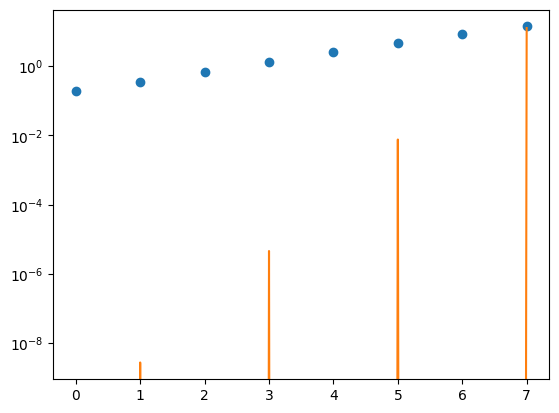

In [78]:
plt.semilogy(np.arange(len(data)), data, 'o', label='Original Data')
plt.semilogy(np.arange(len(data)), fit_curve_weighted, label='Weighted Fit Curve (b)')

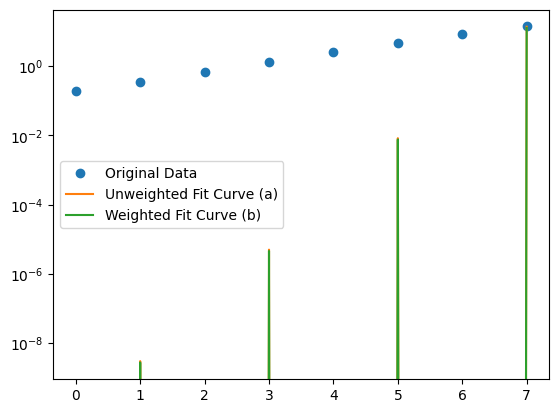

Residuals (Unweighted): [0.19       0.36       0.69000012 1.29999497 2.50020469 4.69167198
 8.83883077 0.21444924]
Residuals (Weighted): [0.19       0.36       0.69000011 1.2999954  2.50018707 4.69238901
 8.80965793 1.40136518]


In [79]:
plt.semilogy(np.arange(len(data)), data, 'o', label='Original Data')
plt.semilogy(np.arange(len(data)), fit_curve, label='Unweighted Fit Curve (a)')
plt.semilogy(np.arange(len(data)), fit_curve_weighted, label='Weighted Fit Curve (b)')
plt.legend()
plt.show()

# Compare residuals
residuals_unweighted = data - fit_curve
residuals_weighted = data - fit_curve_weighted

# Print and compare residuals
print("Residuals (Unweighted):", residuals_unweighted)
print("Residuals (Weighted):", residuals_weighted)

# Exercise 2 (3 points)
A triangle has been measured. The measurements, a vector $x \in \mathbb{R}^6$, are as follows:
$$\begin{array}{c|c|c|c|c|c}
x_1 = \alpha 
& x_2 = \beta
& x_3 = \gamma
& x_4 = a
& x_5 = b
& x_6 = c \\ \hline
67.5^{\large\circ}
& 52^{\large\circ}
& 60^{\large\circ}
& 172 \text{m}
& 146 \text{m}
& 165 \text{m}
\end{array} .
$$
Here $\alpha, \beta, \gamma$ are the angles opposite the sides with length $a$, $b$, $c$, respectively.
The measurements $x$ have errors. We would like to correct them so that the new values $\tilde{x} = x + h$ are consistent quantities of a triangle. The have to satisfy:
$$ \tag{*}
\begin{array}{ccc}
\text{Sum of angles:} 
& \;\;\;\;\; & 
\tilde{x}_1 + \tilde{x}_2 + \tilde{x}_3 = 180^{\large\circ}
\\
\text{Sine theorem:}
&&
\tilde{x}_4 \sin(\tilde{x}_2) - \tilde{x}_5 \sin(\tilde{x}_1) = 0
\\
&&
\tilde{x}_5 \sin(\tilde{x}_3) - \tilde{x}_6 \sin(\tilde{x}_2) = 0 .
\end{array}$$


## (a)
Solve the constrained least squares problem $\min_x \| h \|_2^2$ subject to the constraints given by (*).

Use `scipy.optimize.minimize`.

Hint: Don't forget to work in radians!

Check that for the new values also e.g. the cosine theorem $c^2 = a^2 + b^2 - 2 ab \cos(\gamma)$ holds.

In [101]:
from scipy.optimize import minimize

x_degrees_and_lengths = np.array([67.5, 52, 60, 172, 146, 165])
x_radians = np.radians(x_degrees_and_lengths[:3])

def residuals(h):
    """
    Compute the residuals based on corrected angles and lengths.

    Parameters:
    - h (numpy.ndarray): Optimization parameters representing corrections to angles and lengths.

    Returns:
    - numpy.ndarray: Residuals vector representing the deviation from the constraints.
    """
    tilde_x = np.concatenate([x_radians + h[:3], x_degrees_and_lengths[3:] + h[3:]])

    # constraints
    sum_of_angles_constraint = tilde_x[0] + tilde_x[1] + tilde_x[2] - np.pi
    sine_theorem1_constraint = tilde_x[3] * np.sin(tilde_x[1]) - tilde_x[4] * np.sin(tilde_x[0])
    sine_theorem2_constraint = tilde_x[4] * np.sin(tilde_x[2]) - tilde_x[5] * np.sin(tilde_x[1])

    return np.array([sum_of_angles_constraint, sine_theorem1_constraint, sine_theorem2_constraint])

# constrained least squares optimization
result = minimize(lambda h: np.linalg.norm(residuals(h))**2, x0=np.zeros(6), constraints={'type': 'eq', 'fun': residuals})

tilde_x_corrected = np.concatenate([x_radians + result.x[:3], x_degrees_and_lengths[3:] + result.x[3:]])

# check the cosine theorem
left_side = tilde_x_corrected[5]**2
right_side = tilde_x_corrected[3]**2 + tilde_x_corrected[4]**2 - 2 * tilde_x_corrected[3] * tilde_x_corrected[4] * np.cos(tilde_x_corrected[2])
print(left_side, right_side)
cosine_theorem_check = abs(left_side - right_side)

print("Original angles (rad):\t", x_radians)
print("Corrected angles (rad):\t", tilde_x_corrected[:3])
print("\n")
print("Original lengths:\t", x_degrees_and_lengths[-3:].tolist())
print("Corrected lengths:\t", tilde_x_corrected[-3:].tolist())
print("\n")
print("Cosine theorem check:", cosine_theorem_check)


27224.89308914991 27224.893089148813
Original angles (rad):	 [1.17809725 0.90757121 1.04719755]
Corrected angles (rad):	 [1.16640473 0.89525946 1.07992847]


Original lengths:	 [172.0, 146.0, 165.0]
Corrected lengths:	 [172.00020435357638, 146.00011635665348, 164.99967602740895]


Cosine theorem check: 1.0986695997416973e-09


## (b)
You will notice that the corrections will be made mainly to the angles and much less to the lengths of the sides of the triangle. This is because the measurements have not the same absolute errors. While the error in last digit of the sides is about 1, the errors in radians of the angles are about 0.01. Repeat your computation by taking in account with appropriate weighting the difference in measurement errors. Minimize not simply $\| h \|_2^2$ but
$$
  \left\| \begin{bmatrix} 100 h_1 \\ 100 h_2 \\ 100 h_3 \\ h_4 \\ h_5 \\ h_6 \end{bmatrix} \right\|_2^2.$$

In [102]:
x_degrees_and_lengths = np.array([67.5, 52, 60, 172, 146, 165])
x_radians = np.radians(x_degrees_and_lengths[:3])

# added measurement errors/weights
errors = np.array([0.01, 0.01, 0.01, 1, 1, 1])

def residuals(h):
    """
    Compute the residuals based on corrected angles and lengths.

    Parameters:
    - h (numpy.ndarray): Optimization parameters representing corrections to angles and lengths.

    Returns:
    - numpy.ndarray: Residuals vector representing the deviation from the constraints.
    """
    tilde_x = np.concatenate([x_radians + h[:3], x_degrees_and_lengths[3:] + h[3:]])

    # Constraints
    sum_of_angles_constraint = tilde_x[0] + tilde_x[1] + tilde_x[2] - np.pi
    sine_theorem1_constraint = tilde_x[3] * np.sin(tilde_x[1]) - tilde_x[4] * np.sin(tilde_x[0])
    sine_theorem2_constraint = tilde_x[4] * np.sin(tilde_x[2]) - tilde_x[5] * np.sin(tilde_x[1])

    return np.array([sum_of_angles_constraint, sine_theorem1_constraint, sine_theorem2_constraint])

# weighted least squares optimization
result_weighted = minimize(lambda h: np.linalg.norm(residuals(h) / errors[:3])**2, x0=np.zeros(6), constraints={'type': 'eq', 'fun': residuals})

tilde_x_corrected_weighted = np.concatenate([x_radians + result_weighted.x[:3], x_degrees_and_lengths[3:] + result_weighted.x[3:]])

# check the cosine theorem
left_side_weighted = tilde_x_corrected_weighted[5]**2
right_side_weighted = tilde_x_corrected_weighted[3]**2 + tilde_x_corrected_weighted[4]**2 - 2 * tilde_x_corrected_weighted[3] * tilde_x_corrected_weighted[4] * np.cos(tilde_x_corrected_weighted[2])
cosine_theorem_check_weighted = abs(left_side_weighted - right_side_weighted)

print("Original Angles (degrees): \t\t\t", x_degrees_and_lengths[:3])
print("Corrected Angles (degrees) with weighting: \t", np.degrees(tilde_x_corrected_weighted[:3]))
print("\n")
print("Original Lengths: \t\t\t", x_degrees_and_lengths[3:])
print("Corrected Lengths with weighting: \t", tilde_x_corrected_weighted[3:])
print("\n")
print("Cosine Theorem Check with weighting:", cosine_theorem_check_weighted)


Original Angles (degrees): 			 [67.5 52.  60. ]
Corrected Angles (degrees) with weighting: 	 [66.86487559 51.23482667 61.90029773]


Original Lengths: 			 [172. 146. 165.]
Corrected Lengths with weighting: 	 [172.04467614 145.8778276  165.0378638 ]


Cosine Theorem Check with weighting: 1.7490201571490616e-06
